In [3]:
from typing import Optional
import math
from collections import OrderedDict

import matplotlib
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange, einsum

torch.manual_seed(1234)

### Sinusoidal Positional Encodings

This is used to inject some positional information into the embeddings of the token sequence. Since we compute the next token for every single token in parallel, we want some info about the position of a token within a sequence to be represented as well.
1. Unique encoding for each position (across all sequences)
2. Generalize to longer sequence than seen in training
3. Generated deterministically (so the model can learn it)
4. Linear relation between 2 encoded positions (again to help the model learn relationships)


Given a position $pos$ output a vector $d_{model}$ such that for each location $i$ in the vector the output is $$PE_{pos,2i} = \sin(pos/10000^{2i/d_{model}})$$ $$PE_{pos,2i+1} = \cos(pos/10000^{2i/d_{model}})$$
for even and odd indices respectively

we refactor as $$PE_{pos,2i} = \sin(pos.w)$$ $$PE_{pos,2i+1} = \cos(pos.w)$$ where $w=1/(10000^{2i/d_{model}}) for 0 <= 2i <= d_{model}$

![Sinusoidal PE visualization](fleetwood_sinusoidal.png "https://fleetwood.dev/posts/you-could-have-designed-SOTA-positional-encoding")
Look at the functions. For a dimension $i$ the $sin/cos$ function's wave starts out extremely quickly changing values for small $i$, and slows down a lot up to a wavelength of $10000*2\pi$.

#### Derivation to use tensor ops
$$\frac{1}{10000^{k/d_{model}}} = 10000^{-k/d_{model}} = \exp(\log(10000^{-k/d_{model}}))$$
$$ = \exp(-k/d_{model} * \log(10000))$$
this is basically
$$torch.exp(k * (-\frac{1}{d_{model}}) * \log(10000))$$

In [4]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        """Construct the entire positional encoding."""
        super().__init__()
        w = torch.exp(torch.arange(0, d_model, 2) * (-1/d_model) * math.log(10000))
        PE = torch.zeros([max_len, d_model])
        positions = torch.arange(0, max_len)
        # We have 2 vectors
        assert (positions.shape == (max_len,))
        assert (w.shape == (d_model // 2,))
        # If we reshape positions into a row of columns [[0], [1], [2], ...] then 
        # positions @ w -> gives us a matrix of shape [max_len, d_model/2 ]
        positions = rearrange(positions, "(len column) -> len column", column=1)
        PE[:, 0::2] = torch.sin(positions * w)
        PE[:, 1::2] = torch.cos(positions * w)
        self.register_buffer("PE", PE) # this is not to be a learnable parameter
        # However we do want it to be moved along with model.to(device) 
    
    def forward(self):
        return self.PE

Just a reference implementation with for-loops to demonstrate speedup of torch ops.

In [5]:
# output pe -> [d_model]
def sinusoidal_position_encoding(pos: int, d_model: int = 512) -> torch.Tensor:
    # w = 1/10000**(2i/d_model)
    w = torch.tensor([1/(10_000**(k/d_model)) for k in range(0, d_model, 2)])
    x_indices = pos * w 
    PE_even = torch.sin(x_indices)
    PE_odd = torch.cos(x_indices)
    PE_even = rearrange(PE_even, "(new_dim l) -> l new_dim", new_dim=1)
    PE_odd = rearrange(PE_odd, "(new_dim l) -> l new_dim", new_dim=1)
    interleaved_result = rearrange([PE_even, PE_odd], "function d_model element -> (d_model element function)")
    assert (interleaved_result.shape == (d_model,))
    return interleaved_result

def generate_position_encoding(max_len: int = 5000, d_model: int = 512) -> torch.Tensor:
    all_positions_encoding = torch.zeros([max_len, d_model], dtype=torch.float32)
    for position in range(max_len):
        all_positions_encoding[position, :] += sinusoidal_position_encoding(position, d_model)
    return all_positions_encoding

#### Note below the speed differential of the vectorized pytorch ops. Eye the units 👀

In [6]:
%%timeit
generate_position_encoding()

240 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
SinusoidalPositionalEncoding(512)

341 μs ± 38.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
print(SinusoidalPositionalEncoding(d_model=512).PE.shape)

torch.Size([5000, 512])


In [9]:
def test_sinusoidal_positional_encoding_class():
    max_len = 5000
    d_model = 512
    pe_class = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)
    
    torch.allclose(pe_class.forward(), generate_position_encoding(max_len=max_len, d_model=d_model))

test_sinusoidal_positional_encoding_class()

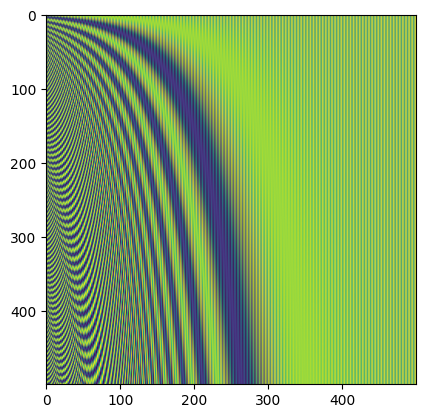

In [148]:
import matplotlib.pyplot


matplotlib.pyplot.imshow((SinusoidalPositionalEncoding(d_model=500, max_len=500).PE).numpy())
matplotlib.pyplot.show()

#### Function that calculates attention (single-headed for now).

#### A Decoder-Only Transformer Language Model

For now we are implementing it with single headed attention

In [10]:
"""
Dimension key:
L: sequence length
D: model dimension (d_model)
V: vocabulary size
F: feed-forward subnetwork's hidden size
K: size of each attention key or value (d_k,d_v,d_kv)
"""

"\nDimension key:\nL: sequence length\nD: model dimension (d_model)\nV: vocabulary size\nF: feed-forward subnetwork's hidden size\nK: size of each attention key or value (d_k,d_v,d_kv)\n"

In [11]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vector_size: int, vocab_size: int):
        super().__init__()
        self.d_model = vector_size
        self.scaling_factor = math.sqrt(self.d_model) # a detail in the paper
        self.lut = nn.Embedding(vocab_size, vector_size)
    
    def forward(self, input_indices: torch.Tensor):
        return self.lut(input_indices) * self.scaling_factor

    def get_weights(self):
        return self.lut.weight

In [12]:
class FeedForward(nn.Module):
    def __init__(self, D: int, H: int = 2048):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(D, H)),
            ("relu1", nn.ReLU()),
            ("linear2", nn.Linear(H, D)),
        ]))
    
    def forward(self, x):
        return self.layers.forward(x)



class Decoder(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int, P_drop: int):
        super().__init__()
        # attention function
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.P_drop = P_drop
        self.W_query_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_key_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_value_DK = nn.Parameter(torch.randn([self.d_model, self.d_v]), requires_grad=True)

        # normalize over the last dimension in shape [N, d_v], so each layer
        self.dropout1 = nn.Dropout(p=self.P_drop)
        self.layernorm1 = nn.LayerNorm(self.d_v)
        self.feedforward = FeedForward(D=self.d_model)
        self.dropout2 = nn.Dropout(p=self.P_drop)
        self.layernorm2 = nn.LayerNorm(self.d_model)
    
    def forward(self, input_BLD: torch.Tensor) -> torch.Tensor:
        assert(input_BLD.dim() == 3 and input_BLD.shape[-1] == self.d_model)
        input_token_length = input_BLD.shape[1]

        Query_BLK = torch.matmul(input_BLD, self.W_query_DK)
        Key_BLK = torch.matmul(input_BLD, self.W_key_DK)
        Value_BLK = torch.matmul(input_BLD, self.W_value_DK)

        attn_values_BLV = self.scaled_dot_prd_attention(Query_BLK, Key_BLK, Value_BLK, visualize_attn=False)
        reg_attn_values_BLV = self.dropout1(attn_values_BLV)
        normalized_attn_values_BLV = self.layernorm1(reg_attn_values_BLV + input_BLD)
        assert(normalized_attn_values_BLV.shape == attn_values_BLV.shape)
        assert(normalized_attn_values_BLV.dim() == 3 and normalized_attn_values_BLV.shape[-1] == self.d_model)

        # print(normalized_attn_values.shape)
        ffn_BLD = self.feedforward(normalized_attn_values_BLV)
        reg_ffn_BLD = self.dropout1(ffn_BLD)

        normalized_ffn_BLD = self.layernorm2(reg_ffn_BLD + normalized_attn_values_BLV)
        return normalized_ffn_BLD
    
    def scaled_dot_prd_attention(self, Query_BLK, Key_BLK, Value_BLK, mask: bool = True, visualize_attn: bool = False) -> torch.Tensor:
        assert (Query_BLK.shape == Key_BLK.shape)

        Key_BKL = rearrange(Key_BLK, "B L K -> B K L")

        qk_BLL = einsum(Query_BLK, Key_BKL, "B S_Q K, B K S_K -> B S_Q S_K")
        scaled_qk_BLL = qk_BLL / math.sqrt(self.d_model)
        # since we want to average the attended keys between the dimension d_k
        if mask:
            tril_qk = torch.tril(scaled_qk_BLL)
            scaled_qk_BLL = torch.where(tril_qk == 0, float("-inf"), scaled_qk_BLL)
        # print(scaled_QK_t_LL)
        # print(scaled_QK_t_LL.shape)
        # raise Exception
        if visualize_attn:
            matplotlib.pyplot.matshow(scaled_qk_BLL[0].cpu().detach().numpy())

        weighted_keys_BLL = torch.softmax(scaled_qk_BLL, dim=-1)
        # print(weighted_keys)
        # raise Exception
        attention_output_BLV = einsum(weighted_keys_BLL, Value_BLK, "B S_Q L , B L D_V -> B S_Q D_V") 
        return attention_output_BLV



In [13]:
def visualize_attention_values():
    d_model, d_k, d_v = 16, 16, 16
    P_drop = 0.1
    dec = Decoder(d_model=16, d_k=d_k, d_v=d_v, P_drop=0.1)
    

In [233]:
class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, num_decoders: int = 6, maximum_sequence_length: int = 5000, P_drop: float = 0.1, vocabulary_size: int = 10000):

        super().__init__()
        assert (num_decoders >= 1)
        self.d_model = d_model
        self.d_k, self.d_v = d_model, d_model
        self.max_sequence_length = maximum_sequence_length
        self.vocabulary_size = vocabulary_size

        self.P_drop = P_drop

        self.positional_encodings = SinusoidalPositionalEncoding(d_model=self.d_model)

        self.emb_dropout = nn.Dropout(p = self.P_drop)
        self.embedding = EmbeddingLayer(vector_size=self.d_model, vocab_size=self.vocabulary_size)
        print("embed info", self.embedding.get_weights().shape)
        self.decoder_stack = nn.Sequential()
        for _ in range(num_decoders):
            self.decoder_stack.append(Decoder(d_model = self.d_model, d_k = self.d_k, d_v = self.d_v, P_drop = self.P_drop))

        self.linear = nn.Linear(self.d_model, self.vocabulary_size)
        self.linear.weight = self.embedding.lut.weight
        self.logsoftmax = nn.LogSoftmax(dim=-1) # this is LogSoftmax so we can get the NLLLoss
    
    def forward(self, input_tokens_BL: torch.Tensor):
        assert(input_tokens_BL.dim() == 2 and input_tokens_BL.dtype == torch.int)
        B, L = input_tokens_BL.shape
        embed_tokens_BLD = self.embedding(input_tokens_BL)
        assert(embed_tokens_BLD.dim() == 3 and embed_tokens_BLD.shape == torch.Size([B, L, self.d_model]))

        pos_enc_LD = self.positional_encodings()[None, :L, ...]
        embed_tokens_BLD += pos_enc_LD

        decoder_output_BLD = self.decoder_stack(embed_tokens_BLD)

        assert(decoder_output_BLD.dim() == 3 and decoder_output_BLD.shape == torch.Size([B, L, self.d_model]))
        linear_output_BLV = self.linear(decoder_output_BLD)
        # next_token_probabilities_BLV = self.logsoftmax(linear_output_BLV)

        return linear_output_BLV
        return next_token_probabilities_BLV # this is of shape [seq_len, vocab_size] (each token has computed a probabilistic next token)
        """Now we map these back to the words based on the maximum token."""


In [174]:
%matplotlib inline
def test_transformer_runs():
    """With a dummy input lets just test if the components of the transformer fit together"""
    input_ints = torch.tensor([1, 2, 3, 4, 3, 6, 5, 7, 8], dtype=torch.int).to("cuda")
    batched_input = torch.stack((input_ints, input_ints))
    model = Transformer(d_model=8).to("cuda")
    print(model.forward(batched_input).shape)

test_transformer_runs()

embed info torch.Size([10000, 8])
torch.Size([2, 9, 10000])


Dataset sample generation

In [275]:
import random

def create_reversed_training_sample(vocab_size: int, max_sequence_length):
    """Generate a palindromic tensor of token indices.
    Returns: [A,Rev(A)]
    """
    random_sample_L = torch.randint(1, vocab_size-1, (max_sequence_length,), dtype=torch.int)
    return torch.cat((random_sample_L, torch.flip(random_sample_L, dims=(0,))))

def test_training_sample_generation():
    test_vocab_size=1000
    sample_length = 40
    gen_sample_L = create_reversed_training_sample(test_vocab_size, sample_length//2)
    assert gen_sample_L.shape == torch.Size([sample_length])
    orig_L, rev_L = torch.tensor_split(gen_sample_L, 2, dim=0)
    assert torch.allclose(orig_L, torch.flip(rev_L, dims=(0,)))

test_training_sample_generation()

In [276]:
START_TOKEN, END_TOKEN = torch.tensor(0, dtype=torch.int32), torch.tensor(0, dtype=torch.int32)

def shift_decoder_input_right(sample_BL: torch.Tensor, start_token: torch.Tensor) -> torch.Tensor:
    st_B = torch.zeros([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([st_B, sample_BL], dim=1)

def pad_input_right(sample_BL: torch.Tensor, end_token: torch.Tensor) -> torch.Tensor:
    ed_B = torch.ones([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([sample_BL, ed_B], dim=1)

In [ ]:
def train_loop(dataloader, model: torch.nn.Module, loss_fn, optimizer, device, epochs, dataset_length: int, scheduler):
    model.train()
    running_loss = []
    running_accuracy = []
    running_reasonable_correct = []
    for ep in range(epochs):
        total_loss = 0
        total_correct = 0
        reasonable_correct = 0
        for idx, batch in enumerate(dataloader):
            batch_BL = batch.to(device)

            optimizer.zero_grad()
            start_input_BL = shift_decoder_input_right(batch_BL, START_TOKEN)
            padded_input_BL = pad_input_right(start_input_BL, END_TOKEN)
            next_token_prob_BLV = model(padded_input_BL)

            first_half_seq_len = padded_input_BL[0].numel()//2
            next_token_prob_BVL = next_token_prob_BLV.transpose(1, 2)
            # mask the first half

            masked_input_BL = padded_input_BL.to(torch.long) # dtype expected by nll_loss
            masked_input_BL[0:first_half_seq_len//2] = -100
            loss = loss_fn(next_token_prob_BVL, masked_input_BL)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (next_token_prob_BLV.argmax(-1) == padded_input_BL).sum().item()
            reasonable_correct += (next_token_prob_BLV[:, first_half_seq_len//2:, ...].argmax(-1) == padded_input_BL[:, first_half_seq_len//2:]).sum().item()

        scheduler.step()

        running_loss.append(loss.item()/dataset_length)
        running_accuracy.append(total_correct / (dataset_length) * batch.shape[-1])
        running_reasonable_correct.append(reasonable_correct / (dataset_length * batch.shape[-1] * .5))
        if ep % 10 == 0:
            print(f"Epoch {ep}:\n")
            print(f"Loss = {running_loss[ep]} Accuracy = {running_accuracy[ep]} Second half correct predictions = {running_reasonable_correct[ep]}")
    
    return running_loss



In [310]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    size = len(dataloader)
    print(f"Test set samples: {size}")
    model.eval()
    test_loss, correct = 0, 0
    total_tokens = 0
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            total_tokens += batch.numel()
            batch_BL = batch.to(device)
            start_input_BL = shift_decoder_input_right(batch_BL, START_TOKEN)
            padded_input_BL = pad_input_right(start_input_BL, END_TOKEN)
            next_token_prob_BLV = model(padded_input_BL)

            first_half_seq_len = batch_BL.shape[1]

            next_token_prob_BVL = next_token_prob_BLV.transpose(1, 2)
            masked_input_BL = padded_input_BL.to(torch.long) # dtype expected by nll_loss
            masked_input_BL[0:first_half_seq_len//2] = -100

            test_loss += loss_fn(next_token_prob_BVL, masked_input_BL).item()
            correct += (next_token_prob_BLV.argmax(dim=-1) == padded_input_BL).sum().item()
    
    test_loss /= total_tokens
    correct /= total_tokens
    print(f"Test error: Accuracy: {100*correct}, Avg loss: {test_loss}\n")

### Train loop

In [329]:
vocab_size = 10
max_sequence_length = 8
dataset_size = 10_000
batch_size = 32
device = torch.device("cuda")
# dataset = [create_reversed_training_sample(vocab_size, max_sequence_length) for _ in range(int(dataset_size))]
dataset = [torch.tensor([2, 3, 4, 5, 5, 4, 3, 2], dtype=torch.int) for _ in range(int(dataset_size))]
train_dataset = dataset[:int(dataset_size * .7)]
test_dataset = dataset[int(dataset_size * .7):]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [330]:
print(len(train_dataset))

7000


In [331]:
model = Transformer(num_decoders=2, d_model=64, maximum_sequence_length=max_sequence_length, vocabulary_size=vocab_size).to(device)

embed info torch.Size([10, 64])


In [332]:

epochs = 400

loss = F.cross_entropy
adam_opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=0.001) # parameters from paper. No LR schedule, default 0.001
scheduler = torch.optim.lr_scheduler.LinearLR(adam_opt)
losses = train_loop(dataloader=train_dataloader, model=model, loss_fn=loss, optimizer=adam_opt, scheduler=scheduler, device=device, epochs=epochs, dataset_length=len(train_dataset))

Epoch 0:

Loss = 7.236835147653308e-06 

Accuracy = 64.98514285714286

Second half correct predictions = 1.6018928571428572
Epoch 10:

Loss = 9.78885119755952e-10 

Accuracy = 79.96457142857143

Second half correct predictions = 1.9989642857142857
Epoch 20:

Loss = 2.76265771909883e-10 

Accuracy = 79.97714285714285

Second half correct predictions = 1.9992857142857143
Epoch 30:

Loss = 1.2385377802713395e-12 

Accuracy = 79.99428571428571

Second half correct predictions = 1.9998928571428571
Epoch 40:

Loss = 1.4707630668908678e-12 

Accuracy = 79.99314285714286

Second half correct predictions = 1.9998571428571428
Epoch 50:

Loss = 6.192689535769854e-13 

Accuracy = 79.99885714285715

Second half correct predictions = 2.0
Epoch 60:

Loss = 0.0 

Accuracy = 80.0

Second half correct predictions = 2.0
Epoch 70:

Loss = 0.0 

Accuracy = 80.0

Second half correct predictions = 2.0
Epoch 80:

Loss = 0.0 

Accuracy = 80.0

Second half correct predictions = 2.0
Epoch 90:

Loss = 0.0 

Accur

In [333]:
test_op = model(train_dataset[0].unsqueeze(0).to(device))
print(test_op)
print(test_op.argmax(-1))

tensor([[[-24.5320, -10.6882,  32.7161,  -9.0806,  12.3446,  -7.2517,  -6.6320,
           -7.3685,  -5.9645, -10.2259],
         [-28.6331, -14.3044,   8.4613,  19.7274,   5.6406, -10.7020, -16.7199,
           -8.3006,  -7.9565, -19.2220],
         [-10.9163,  -8.9876, -20.5724, -14.2604,  33.3173,  -6.9555,  -6.4133,
           -8.4990, -18.6758, -16.4575],
         [-14.9754, -10.4768, -22.1659, -21.9128,  -5.9128,  27.2658,  -9.2945,
           -8.0912,  -9.6148, -13.0054],
         [-21.6945,  -8.9962, -12.8930, -18.9585,  -4.3464,  28.2434,  -8.8165,
           -7.2628, -10.2578, -13.4173],
         [ -9.6940, -10.8313, -22.6866, -14.4592,  35.7538,  -4.9190,  -7.0228,
           -9.0969, -19.8084, -11.8283],
         [-29.4343,  -8.8123, -22.0460,   8.2027,  -0.5755,  17.5880, -12.2746,
           -8.9796,  -9.0813, -18.7755],
         [-16.9393,  -6.3619,  37.6886, -16.6514,  -0.5843,  -0.9912,  -2.8352,
           -9.8422,  -4.0607, -10.5000]]], device='cuda:0',
       grad_f

Accuracy should be 50% ish since the model should only know the second half of the tokens.

In [334]:

test_loop(test_dataloader, model, loss, device)

Test set samples: 94
Test error: Accuracy: 125.0, Avg loss: 0.0



In [340]:
def inference(model, sample, device: torch.device):
    model.eval()
    print(f"Sample {sample}\n")
    input_BL = sample.to(device)
    result_BL = []
    with torch.no_grad():
        total_tokens = sample.numel()
        print(f"Total Sample length {total_tokens}\n")

        
        start_input_BL = shift_decoder_input_right(input_BL, START_TOKEN)
        padded_input_BL = pad_input_right(start_input_BL, END_TOKEN)
        seq_next_token_probabilities_BLV = model(padded_input_BL)

        result_BL = seq_next_token_probabilities_BLV.argmax(dim=-1)

    print(result_BL == padded_input_BL)
    print(result_BL)
    return result_BL

random_sample_L = create_reversed_training_sample(vocab_size, max_sequence_length)
random_sample_L = train_dataset[1]
random_sample_BL = rearrange(random_sample_L, "(B L) -> B L", B = 1)
print(random_sample_BL.shape)
# print(random_sample)
# print(random_sample[:2])
result = torch.tensor(inference(model, random_sample_BL, device))
        



torch.Size([1, 8])
Sample tensor([[2, 3, 4, 5, 5, 4, 3, 2]], dtype=torch.int32)

Total Sample length 8

tensor([[True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')
tensor([[0, 2, 3, 4, 5, 5, 4, 3, 2, 1]], device='cuda:0')


/tmp/ipykernel_3615746/2184308747.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(inference(model, random_sample_BL, device))
